In [98]:
# Save and restore models for additional training
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use this plot style
%matplotlib inline

In [99]:
def normalize(array):
    u = array.mean()
    s = array.std()
    norm = (array - u) / s
    return u, s, norm

def min_max(array, min=0, max=1):
    X_std = (array - array.min(axis=0)) / (array.max(axis=0) - array.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [100]:
from scipy.stats import gaussian_kde

N = 10000
def generate_original_data(size=N):
    Wafer1 = np.random.normal(loc = 0.0, scale = 1.0, size = N)
    Wafer2 = np.random.normal(loc = 2.0, scale = 1.0, size = N)
    pdf1 = gaussian_kde(Wafer1)
    pdf2 = gaussian_kde(Wafer2)
    pdf1.set_bandwidth(bw_method=pdf1.factor / 3.)
    pdf2.set_bandwidth(bw_method=pdf2.factor / 3.)
    return Wafer1,Wafer2,pdf1, pdf2

# Wafer1,Wafer2,pdf1,pdf2 = generate_original_data(size=N)

In [101]:
def generate_experiment_data(size=N):
    Wafer1,Wafer2,pdf1,pdf2 = generate_original_data(size=N)
    X1 = np.linspace(min(Wafer1), max(Wafer1), num=N)
    X_pool = pdf1(X1)
    X_pool = np.reshape(X_pool, (N,1))
    X2 = np.linspace(min(Wafer2), max(Wafer2), num=N)
    Y_pool = pdf2(X2)
    Y_pool = np.reshape(Y_pool, (N,1))

    # sample size of 15%
    sample = int(N * 0.15)
    # 15% test
    test_x = X_pool[0:sample]
    # 15% validation
    valid_x = X_pool[sample:sample*2]
    # 70% training
    train_x = X_pool[sample*2:]
    print('Testing data points: ' + str(test_x.shape))
    print('Validation data points: ' + str(valid_x.shape), type(valid_x))
    print('Training data points: ' + str(train_x.shape))
    # Let's compute the ouput using 2 for a and 2 for b
    test_y = Y_pool[0:sample]
    valid_y = Y_pool[sample:sample*2]
    train_y = Y_pool[sample*2:]

    # scale x and y (I choose to only scale y since x seemed already to be close enough to min=0, max=1)
    #test_x = min_max(test_x)
    test_y = min_max(test_y)
    #valid_x = min_max(valid_x)
    valid_y = min_max(valid_y)
    #train_x = min_max(train_x)
    train_y = min_max(train_y)
    # Normalize x and y (I choose to only normalize y since x seemed already to be close enough to mean=0, std=1)
    #u_test_x, s_test_x, test_x = normalize(test_x)
    u_test_y, s_test_y, test_y = normalize(test_y)
    #u_valid_x, s_valid_x, valid_x = normalize(valid_x)
    u_valid_y, s_valid_y, valid_y = normalize(valid_y)
    #u_train_x, s_train_x, train_x = normalize(train_x)
    u_train_y, s_train_y, train_y = normalize(train_y)
    
    return train_x, train_y,valid_x,valid_y,test_x,test_y

In [102]:
# Helper Function
def add_layer(inputs, in_size, out_size, activation_function=None):
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

In [103]:
hidden_size = 10
# placeholders
# shape=[how many samples do you have, how many input neurons]
x = tf.placeholder(tf.float32, shape=[None, 1], name="01_x")
y = tf.placeholder(tf.float32, shape=[None, 1], name="01_y")

# drop out
keep_prob = tf.placeholder(tf.float32)

# create your hidden layers!
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)
# here is where we shoot down some of the neurons
h1_drop = tf.nn.dropout(h1, keep_prob)
# add a second layer
h2 = add_layer(h1_drop, hidden_size, hidden_size, tf.nn.relu)
h2_drop = tf.nn.dropout(h2, keep_prob)
# add a third layer
h3 = add_layer(h2_drop, hidden_size, hidden_size, tf.nn.relu)
h3_drop = tf.nn.dropout(h3, keep_prob)
# add a fourth layer
h4 = add_layer(h3_drop, hidden_size, hidden_size, tf.nn.relu)
h4_drop = tf.nn.dropout(h4, keep_prob)

# Output Layers
pred = add_layer(h4_drop, hidden_size, 1)

# minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(pred - y))
# pick optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [104]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0
# Iteration-number for last improvement to validation accuracy.
last_improvement = 0
# Stop optimization if no improvement found in this many iterations.
require_improvement = 1500

In [106]:
# initialize the variables
init = tf.global_variables_initializer()
# hold step and error values
t = []
size_list = [i for i in range(100, 10000, 1000)]
accuracies = []
# Run your graph
with tf.Session() as sess:
    # initialize variables
    sess.run(init)
    for index in size_list:
        train_x, train_y,valid_x,valid_y,test_x,test_y = generate_experiment_data(index)
        # Fit the function.
        for step in range(6000):
            # get your data
            train_data = {x:train_x, y:train_y, keep_prob: 0.975}
            valid_data = {x:valid_x, y:valid_y, keep_prob: 1.0}
            test_data = {x:test_x, y:test_y, keep_prob: 1.0}
            # training in progress...
            train_loss, train_pred = sess.run([loss, train], feed_dict=train_data)        
            # print every n iterations
            if step%100==0:
                # capture the step and error for analysis
                valid_loss = sess.run(loss, feed_dict=valid_data) 
                t.append((step, train_loss, valid_loss))    
                # get snapshot of current training and validation accuracy       
                train_acc = accuracy.eval(train_data)
                valid_acc = accuracy.eval(valid_data)           
                # If validation accuracy is an improvement over best-known.
                if valid_acc > best_valid_acc:
                    # Update the best-known validation accuracy.
                    best_valid_acc = valid_acc
                    # Set the iteration for the last improvement to current.
                    last_improvement = step
                    # Flag when ever an improvement is found
                    improved_str = '*'
                else:
                    # An empty string to be printed below.
                    # Shows that no improvement was found.
                    improved_str = ''   

                print("Training loss at step %d: %f %s" % (step, train_loss, improved_str))        
                print("Validation %f" % (valid_loss))            

                # If no improvement found in the required number of iterations.
                if step - last_improvement > require_improvement:
                    print("No improvement found in a while, stopping optimization.")
                    # Break out from the for-loop.
                    break                

        # here is where you see how good of a Data Scientist you are        
        print("Accuracy on the Training Set:", accuracy.eval(train_data))
        print("Accuracy on the Validation Set:", accuracy.eval(valid_data)) 
        print("Accuracy on the Test Set:", accuracy.eval(test_data))
        accuracies.append(accuracy.eval(train_data))

Testing data points: (1500, 1)
Validation data points: (1500, 1) <class 'numpy.ndarray'>
Training data points: (7000, 1)
Training loss at step 0: 1.140019 
Validation 1.127507
Training loss at step 100: 0.985999 
Validation 0.995302
Training loss at step 200: 0.977773 
Validation 0.992573
Training loss at step 300: 0.963248 
Validation 0.987836
Training loss at step 400: 0.937316 
Validation 0.978585
Training loss at step 500: 0.878229 
Validation 0.956988
Training loss at step 600: 0.692062 
Validation 0.890578
Training loss at step 700: 0.232598 
Validation 0.724202
Training loss at step 800: 0.071782 
Validation 0.808550
Training loss at step 900: 0.048865 
Validation 0.880388
Training loss at step 1000: 0.043219 
Validation 0.897817
Training loss at step 1100: 0.042562 
Validation 0.897710
Training loss at step 1200: 0.040020 
Validation 0.903474
Training loss at step 1300: 0.040146 
Validation 0.902440
Training loss at step 1400: 0.041229 
Validation 0.899735
Training loss at step

Training loss at step 3200: 0.036300 
Validation 1.482343
Training loss at step 3300: 0.035650 
Validation 1.483997
Training loss at step 3400: 0.034978 
Validation 1.486492
Training loss at step 3500: 0.035949 
Validation 1.484438
Training loss at step 3600: 0.034261 
Validation 1.486522
Training loss at step 3700: 0.033733 
Validation 1.488932
Training loss at step 3800: 0.035216 
Validation 1.488672
Training loss at step 3900: 0.034580 
Validation 1.485030
Training loss at step 4000: 0.033654 
Validation 1.490167
No improvement found in a while, stopping optimization.
Accuracy on the Training Set: 0.85714287
Accuracy on the Validation Set: 0.41666666
Accuracy on the Test Set: 0.46733335
Testing data points: (1500, 1)
Validation data points: (1500, 1) <class 'numpy.ndarray'>
Training data points: (7000, 1)
Training loss at step 0: 0.045135 
Validation 1.189311
Training loss at step 100: 0.042808 
Validation 1.145568
Training loss at step 200: 0.043866 
Validation 1.143491
Training lo

Training loss at step 3600: 0.077408 
Validation 1.743347
Training loss at step 3700: 0.079622 
Validation 1.746759
Training loss at step 3800: 0.077771 
Validation 1.745658
Training loss at step 3900: 0.077770 
Validation 1.742620
Training loss at step 4000: 0.077736 
Validation 1.726792
No improvement found in a while, stopping optimization.
Accuracy on the Training Set: 0.7814286
Accuracy on the Validation Set: 0.48333332
Accuracy on the Test Set: 0.5273333
Testing data points: (1500, 1)
Validation data points: (1500, 1) <class 'numpy.ndarray'>
Training data points: (7000, 1)
Training loss at step 0: 0.047856 
Validation 1.962086
Training loss at step 100: 0.032429 
Validation 2.085629
Training loss at step 200: 0.032650 
Validation 2.109011
Training loss at step 300: 0.031929 
Validation 2.110198
Training loss at step 400: 0.032911 
Validation 2.116784
Training loss at step 500: 0.031465 
Validation 2.120842
Training loss at step 600: 0.033065 
Validation 2.116729
Training loss at 

Training loss at step 4000: 0.035817 
Validation 1.689527
No improvement found in a while, stopping optimization.
Accuracy on the Training Set: 0.8371429
Accuracy on the Validation Set: 0.43066666
Accuracy on the Test Set: 0.5086667


[0.8798571, 0.853, 0.8447143, 0.85728574, 0.9035714, 0.7245714, 0.77842855, 0.8765714, 0.851, 0.8462857]


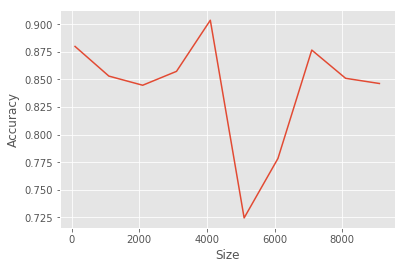

0.84152853


In [108]:
print(accuracies)
plt.plot(size_list, accuracies)
plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.show()
print(np.average(accuracies))